## Environment setup

### Library preparation

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import qcodes as qc
# from qcodes import Station, load_by_run_spec, load_by_guid
# from qcodes.instrument.base import Instrument
# from qcodes.dataset.experiment_container import (Experiment,
#                                                  load_last_experiment,
#                                                  new_experiment)
# from qcodes.dataset.database import initialise_database
# from qcodes.dataset.measurements import Measurement
# from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
# from qcodes.dataset.data_set import load_by_id
# # from qcodes.dataset.data_export import get_shaped_data_by_runidb

In [5]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
from qcodes.instrument_drivers.tektronix.AWG3252_Isrc import AWG3252_Isrc
from qcodes.instrument_drivers.HP.HP34401 import HP34401
from qcodes.instrument_drivers.HP.HP34401_DL1201 import HP34401_DL1201
from qcodes.instrument_drivers.Keithley.Keithley_2600_channels import *
from qcodes.instrument_drivers.tektronix.AWG5204_Isrc import AWG5204_Isrc

from qcodes.instrument_drivers.Keysight.Keysight_B2962A_Isrc import B2962A_Isrc


from qcodes.instrument_drivers.Keithley.Keithley_6220 import Keithley_6220
from qcodes.instrument_drivers.Keithley.Keithley_6220_Isrc import Keithley_6220_Isrc

In [6]:
import sys 
sys.path.append('..\..\_jjtools')

# from Exps import *

from JJ_data_processing import read_opj_data, pbi, bpbi, show_df, update_df

from JJformulas import *
# from meas_util import *

from JJmeasurement import *

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'
C:\Users\KelvinOX25\Anaconda3\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Instrument nicknames and QC database initialization

In [7]:
try:
   Instrument.close_all()
except KeyError:
   pass    
except NameError:
   pass 

K2602 =  Keithley_2600(name = 'K2602', address = "GPIB::26::INSTR" )
Flux_chA = K2602.smua.curr
Flux_chB = K2602.smub.curr

Bfield =  Flux_chA
Bfield.step = 10e-6
Bfield.inter_delay = .1



# Isrc = AWG5204_Isrc('gen', 'TCPIP0::AWG52000-XXXX::inst0::INSTR', ch = 1, R_bias = 1e9, Attn = 1, timeout = 20)


# Isrc = Keithley_6220(name = 'K6220', address = "GPIB::13::INSTR" )
# Isrc.set_R_Attn ( R_bias = 1, Attn = 1 )




# Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR', 
#                     R_bias = 1e9, Attn = 10)
# Isrc.init()

Vmeter = HP34401_DL1201('meter', 'GPIB0::8::INSTR', Gain = 1e2)
Vmeter.init('fast 6')


# Isrc = Keithley_6220_Isrc(name = 'K6220', address = "GPIB::13::INSTR",
#                           Rsh = 10e6, Rb = 1e9, Vmeter = Vmeter)


Isrc = Keithley_6220_Isrc(name = 'K6220', address = "GPIB::13::INSTR",
                          Rsh = 10.041e3, Rb = 2.2e6, Vmeter = Vmeter)


station = qc.Station(Isrc, Vmeter)

print ('Instrument initialization completed.')

Connected to: Keithley Instruments Inc. 2602A (serial:1272049, firmware:2.1.5) in 0.70s


[K6220(Keithley_6220_Isrc)] Snapshot: Could not update parameter: Irange


Instrument initialization completed.


In [8]:

LS370 = Model_372(name = 'LS370 input Ch', address = 'GPIB::12::INSTR', terminator='\n')
T8 = LS370.ch08.temperature

htr = LS370.sample_heater
htr_setpt = htr.setpoint

htr_setpt.set(0.020)
htr.P.set(30)
htr.I.set(5)
htr.D.set(1)
# PIDset(30,5,1)
htr.output_range('3.16mA')

Connected to: LSCI 370 (serial:370665, firmware:04102008) in 0.12s


### Class JJmeas

In [9]:
tools = {'I' : Isrc.I,
         'V' : Vmeter.V,
         'B' : Flux_chA,
         'T': T8,
         'htr' : htr_setpt}

In [10]:
def setup():
    Isrc.I.set(0)
#     pass

def cleanup():
    Isrc.I.set(0) 
#     Bfield.set(0)



In [30]:
jj = JJmeas(sample = 'D085N1', tools = tools)
jj.setup = setup
jj.cleanup = cleanup

jj.ZF   = -10e-6
jj.FF   = 215e-6

In [12]:
jj.tool_status(['B', 'T'])

{'B': '179.9 µA', 'T': '66.2 mK'}

## Measurement

In [31]:
Bfield.set(0)

#### Iscr choise

In [25]:
Isrc.ask_raw('SOUR:CURR:RANG?')

'2.000000E-04\n'

In [24]:
Isrc.write_raw('SOUR:CURR:RANG 1e-6')
Isrc.I.set(0.0e-9)

#### Vmeter regime

In [18]:
Vmeter.init('fast 6')

In [152]:
jj.meas_Voffset(0)

5.9592217e-05

### IVCs

In [330]:
jj.stabilize_I( amp = 100e-9)

#### wide scan

In [13]:
Isrc.ask_raw('SOUR:CURR:RANG?')

'2.000000E-04\n'

In [40]:
Isrc.write_raw('SOUR:CURR:RANG 1e-8')

In [47]:
Isrc.write_raw('SOUR:CURR:RANG 1e-5')

#B = jj.cos_to_B(0)

# B = 205e-6
# B = -750e-6
B = 0e-6

print(B*1e3)

Bfield.set(B)


jj.IVC_udu (amp = 5e-9, stp = .05e-9, dt = .1,  N_avg = 1, 
            label = 'kei full ivc 1e  B = {}A'.format(si_format(B)))

0.0


Starting experimental run with id: 12


An exception occured in measurement with guid: aaaaaaaa-0000-0000-0000-01747efbd14e;
Traceback:
Traceback (most recent call last):
  File "..\..\_jjtools\JJmeasurement.py", line 81, in IVC_cust
    I.set(i+Ioff)
  File "C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\instrument\parameter.py", line 554, in set_wrapper
    set_function(raw_value, **kwargs)
  File "C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\utils\command.py", line 178, in __call__
    return self.exec_function(*args)
  File "C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\utils\command.py", line 127, in call_by_str
    return self.exec_str(self.cmd_str.format(*args))
  File "C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\instrument\base.py", line 719, in write
    self.write_raw(cmd)
  File "C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\instrument\visa.py", line 212, in write_raw
    nr_bytes_written, ret_code = self.visa_handle.write(cmd)
  File "C:\Users\KelvinOX25\Anaconda3\li

KeyboardInterrupt: 

##### WS

In [ ]:
tlst = []
segName = '5b'

t0 = time.time()
Bfield.set(0)
Blst = [ZF,FF]
for B in Blst:
    Bfield.set(B)
    print('setting B:{}A'.format(si_format(B)))
    jj.IVC_udu (amp = 0.2e-6, stp = 5e-9, dt = .1,  N_avg = 1, 
                label = 'kei IVf B:{}A, {}'.format(si_format(B),segName))
tlst += [(time.time()-t0)/60]
    
t0 = time.time()
Bfield.set(0)
Blst = np.arange(100e-6,350e-6,5e-6)-190e-6
for B in Blst:
    Bfield.set(B)
    print('setting B:{}A'.format(si_format(B)))
    jj.IVC_udu (amp = 0.2e-6, stp = 5e-9, dt = .1,  N_avg = 1, 
                label = 'kei Bscan fine_ZF B:{}A, {}'.format(si_format(B),segName))
tlst += [(time.time()-t0)/60]

t0 = time.time()
Bfield.set(0)
Blst = np.arange(100e-6,350e-6,5e-6)
for B in Blst:
    Bfield.set(B)
    print('setting B:{}A'.format(si_format(B)))
    jj.IVC_udu (amp = 0.1e-6, stp = 2e-9, dt = .1,  N_avg = 1, 
                label = 'kei Bscan fine_FF B:{}A, {}'.format(si_format(B),segName))
tlst += [(time.time()-t0)/60]

print(tlst)

In [ ]:
segName = '5b'

Blst = [0]*40
for B in Blst:
    Bfield.set(B)
    print('setting B:{}A'.format(si_format(B)))
    jj.IVC_udu (amp =0.3e-6, stp = 2e-9, dt = .1,  N_avg = 1, 
                label = 'kei peri. stoch B:{}A, {}'.format(si_format(B),segName))

In [ ]:
segName = '5b'

Bfield.set(0)
Blst = np.linspace(1.7,2.1,9)*1e-4
for B in Blst:
    Bfield.set(B)
    print('setting B:{}A'.format(si_format(B)))
    jj.IVC_udu (amp = 0.020e-6, stp = 0.5e-9, dt = .1,  N_avg = 1, 
                label = 'kei B:{}A, {}'.format(si_format(B),segName))

In [ ]:
jj.B_to_cos(140e-6)

#### fine scan

In [43]:
Isrc.write_raw('SOUR:CURR:RANG 1e-7')

In [213]:
Isrc.ask_raw('CURR:RANG?')

'2.000000E-07\n'

In [77]:
Isrc.write_raw('SOUR:CURR:RANG 2e-6')

dev = '1d'
B = 0e-6

Bfield.set(B)
jj.IVC_udu (amp = 200e-12, stp = 1e-12, dt = .1,  N_avg = 50, 
            label = dev+' Navg = 50 B = {}A'.format(si_format(B)))

Starting experimental run with id: 39


39

In [70]:
Isrc.write_raw('SOUR:CURR:RANG 10e-6')

dev = '1d'
B = 0e-6

Bfield.set(B)
jj.IVC_udu (amp = 4e-9, stp = 0.2e-9, dt = .1,  N_avg = 1, 
            label = dev+' scan B = {}A'.format(si_format(B)))

Starting experimental run with id: 32


32

##### WS

In [59]:
dev = 'b'
dev = 'c'
dev = 'b-5f'
B = 0

Bfield.set(B)
jj.IVC_udu (amp = 150e-9, stp = 5e-9, dt = .1,  N_avg = 1, 
            label = '5'+dev+' ZF')

KeyboardInterrupt: 

In [ ]:
segName = 'f'

Bfield.set(0)
T0 = time.time()
Blst = np.linspace(200,230,31)*1e-6
for B in Blst:
    Bfield.set(B)
    print('setting B:{}A'.format(si_format(B)))
    jj.IVC_udu (amp = 0.4e-9, stp = 0.004e-9, dt = .1,  N_avg = 1, 
                label = 'kei B:{}A, {}'.format(si_format(B),segName))
print(f'time cost:{(time.time()-T0)//60}')

In [287]:
Isrc.ask_raw('CURR:RANG?')

'2.000000E-05\n'

In [ ]:
segName = 'b_new'
Isrc.write_raw('CURR:RANG 200e-6')

Bfield.set(0)
T0 = time.time()
Blst = np.linspace(-3*FF, 3*FF, 21)
for B in Blst:
    Bfield.set(B)
    print('setting B:{}A'.format(si_format(B)))
    jj.IVC_udu (amp = 200e-9, stp = 1e-9, dt = .1,  N_avg = 1, 
                label = 'kei IVc B:{}A, {}'.format(si_format(B),segName))
print(f'time cost:{(time.time()-T0)//60}')

In [325]:
Bfield.set(0)
jj.IVC_udu (amp = 200e-9, stp = 1e-9, dt = .1,  N_avg = 1, 
                label = 'kei IVc B:{}A, {}'.format(si_format(B),segName))

Starting experimental run with id: 1336


1336

In [ ]:
segName = 'b_new'
Isrc.write_raw('CURR:RANG 200e-6')

Bfield.set(0)
T0 = time.time()
Blst = np.linspace(-3*FF, 3*FF, 19)
for B in Blst:
    Bfield.set(B)
    print('setting B:{}A'.format(si_format(B)))
    jj.IVC_udu (amp = 200e-9, stp = 4e-9, dt = .1,  N_avg = 1, 
                label = 'kei IVc B:{}A, {}'.format(si_format(B),segName))
print(f'time cost:{(time.time()-T0)//60}')

In [ ]:
segName = 'c'

Bfield.set(0)
T0 = time.time()
# Blst = [ZF,150e-6,160e-6,170e-6,180e-6,185e-6,190e-6,FF]
# Blst = np.append(np.linspace(195,200,11)*1e-6,(np.linspace(195,230, 9)*1e-6)[2:])
Blst = np.append(np.linspace(195,200,11)*1e-6,np.linspace(200,230,61)*1e-6)
for B in Blst:
    Bfield.set(B)
    print('setting B:{}A'.format(si_format(B)))
#     jj.IVC_udu (amp = 20e-9, stp = 0.2e-9, dt = .1,  N_avg = 1, 
#     jj.IVC_udu (amp = 2e-9, stp = 0.02e-9, dt = .1,  N_avg = 1, 
    jj.IVC_udu (amp = .4e-9, stp = 0.004e-9, dt = .1,  N_avg = 1, 
                label = 'kei IVc B:{}A, {}'.format(si_format(B),segName))
print(f'time cost:{(time.time()-T0)//60}')

In [ ]:
segName = 'b'

Bfield.set(0)
T0 = time.time()
Blst = [150e-6,160e-6,170e-6,180e-6] #runid 544,545,546,547
# Blst = np.linspace(180,230,11)*1e-6 #runid range(550, 560+1)
# Blst = np.linspace(195,230,9)*1e-6 #runid range(561,569+1)
Blst = np.linspace(195,200,11)*1e-6
for B in Blst:
    Bfield.set(B)
    print('setting B:{}A'.format(si_format(B)))
    jj.IVC_udu (amp = 20e-9, stp = 0.2e-9, dt = .1,  N_avg = 1, 
#     jj.IVC_udu (amp = 2e-9, stp = 0.02e-9, dt = .1,  N_avg = 1, 
#     jj.IVC_udu (amp = 0.4e-9, stp = 0.004e-9, dt = .1,  N_avg = 1, 
                label = 'kei B:{}A, {}'.format(si_format(B),segName))
print(f'time cost:{(time.time()-T0)//60}')

In [313]:
Isrc.write_raw('CURR:RANG 2e-6')

In [314]:
dev = 'b'
B = 180e-6

Bfield.set(B)
jj.IVC_udu (amp = 2e-9, stp = 20e-12, dt = .1,  N_avg = 1, 
            label = '5'+dev+' fine scan B = {}A'.format(dev, si_format(B)))

Starting experimental run with id: 1224


1224

In [312]:
dev = 'b'
B = 180e-6

Bfield.set(B)
jj.IVC_udu (amp = 20e-9, stp = 200e-12, dt = .1,  N_avg = 1, 
            label = '5'+dev+' fine scan B = {}A'.format(dev, si_format(B)))

Starting experimental run with id: 1223


1223

In [244]:
# B = jj.cos_to_B(0.15)
# B = 205e-6

B = 0

print(B*1e3)

Bfield.set(B)
jj.IVC_udu (amp = 2e-9, stp = 5e-12, dt = .1,  N_avg = 1, 
            label = '5b fine scan B = 205, 4b2a;1b3b')

0.205


Starting experimental run with id: 1012


1012

In [254]:
Isrc.ask_raw('CURR:RANG?')

'2.000000E-06\n'

In [256]:
B = 205e-6

Bfield.set(B)
jj.IVC_udu (amp = 2e-9, stp = 5e-12, dt = .1,  N_avg = 1, 
            label = '5f fine scan B = 205, 4b2a;1b3b')

Starting experimental run with id: 1016


1016

In [ ]:
imin = .5e-12

i_list =   np.concatenate ([np.linspace(0    , 35e-12, 21), 
                            np.linspace(12e-12, imin, 21),
                            np.linspace(imin, 12e-12, 251),
                            np.linspace(12e-12,  0e-12, 21)]) 

jj.IVC_cust ( i_list, Ioff = 0, dt = 0.1, N_avg = 1, label = 'B=0m intermid steps')

### Ic meas

In [572]:
B = 0e-6
Bfield.set(B)

i_list = np.linspace(0, 200e-12, 101)

jj.IVC_cust (i_list, Vthr = 30e-6, dt = 0.1,
             N_avg = 1, label = 'Kei Ic highRb RT cos = 1')

Starting experimental run with id: 1185


1185

### Time scan

In [513]:
# Bfield.set(0e-3)
jj.time_scan ( tools['I'], dur = 30, dt= 0.1)

Starting experimental run with id: 1093



1093

In [ ]:
B_list = np.linspace(0e-3, .3e-3, 51)

[            jj.time_scan ( tools['V'], dur = 1, dt= 0.01)
for jj in    jj.Bscan( B_list = B_list )]

### IVC B

In [272]:
jj.stabilize_I( amp = 1e-9)

#### New syntaxis to try

In [ ]:

cos_list = np.linspace(0.12, 0.22, 11)
B_list = np.linspace(230e-6, 220e-6, 21)


Isrc.write_raw('SOUR:CURR:RANG 20e-6')


[            jj.IVC_udu (amp = .3e-9, stp = 10e-12, dt = .1,
                         N_avg = 1, label = ' 5b look for N')
for jj in    jj.Bscan( B_list = B_list )]


# Bfield.set(0)


In [ ]:

cos_list = np.linspace(0.12, 0.22, 11)
B_list = np.linspace(230e-6, 220e-6, 21)


# Isrc.write_raw('SOUR:CURR:RANG 1e-7')


[            jj.IVC_udu (amp = .3e-9, stp = 10e-12, dt = .1,
                         N_avg = 1, label = ' 5c look for N')
for jj in    jj.Bscan( B_list = B_list )]


# Bfield.set(0)


In [ ]:

B_list = [0]*100

Isrc.write_raw('SOUR:CURR:RANG 1e-4')


[            jj.IVC_udu (amp = 200e-9, stp = 2e-9, dt = .1,  N_avg = 1, 
            label = '5b-5f repeatative scan')
for jj in    jj.Bscan( B_list = B_list )]


# Bfield.set(0)


#### Ic(B)

In [ ]:
i_list = np.linspace(0, 1e-9, 501)

cos_list = np.linspace(0.12, 0.22, 11)

Isrc.write_raw('SOUR:CURR:RANG 1e-7')



[            jj.IVC_cust ( i_list, Vthr = 10e-6, dt = 0.1, N_avg = 1, label = '5d fine Ic(B)')
for jj in    jj.Bscan( cos_list = cos_list )]



In [ ]:
i_list = np.linspace(0, 10e-9, 501)

cos_list = np.linspace(0.23, 0.43, 21)

Isrc.write_raw('SOUR:CURR:RANG 1e-6')



[            jj.IVC_cust ( i_list, Vthr = 10e-6, dt = 0.1, N_avg = 1, label = '5d fine Ic(B)')
for jj in    jj.Bscan( cos_list = cos_list )]



In [ ]:
i_list = np.linspace(0, 200e-9, 201)

# cos_list = np.linspace(0.44, 1, 57)
B_list = np.linspace(-1000e-6, 1000e-6, 51)

Isrc.write_raw('SOUR:CURR:RANG 1e-4')



[            jj.IVC_cust ( i_list, Vthr = 10e-6, dt = 0.1, N_avg = 1, label = ' 5b coarse Ic(B)')
for jj in    jj.Bscan( B_list = B_list )]



#### saving Isw(B)

In [22]:
Isw_param = Parameter(name = 'Isw', label = 'Switching current',
                      unit = 'A') 

cos_param = Parameter(name = 'cos', label = 'cos',
                      unit = '')

Ej_param = Parameter(name = 'Ej', label = 'Ej',
                      unit = 'K')

B_param = Parameter(name = 'Bfield', label = 'Bfield',
                      unit = 'A')

..\..\_jjtools\JJ_data_processing.py:276: RuntimeWarning: invalid value encountered in less
  ind1 = np.where(np.abs(vA0) < dx )
C:\Users\KelvinOX25\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\KelvinOX25\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


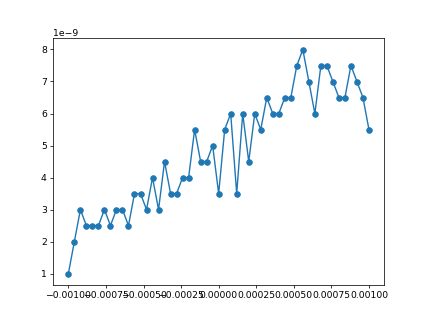

Starting experimental run with id: 1525


1525

In [23]:
ids = range(1474, 1524+1)

B_list = np.linspace(-1000e-6, 1000e-6, 51)

Ics = jj.Isw_by_id(ids, fullIVC = True, dy = 10e-6)

Ej0 = 5.8/6

fig, ax = plt.subplots()
# ax.plot(cos_list, Ics, 'o-')
ax.plot(B_list, Ics, 'o-')


jj.mock_meas((Isw_param , Ics), (B_param, B_list),
             label = 'Isw vs B segs bf coarse scan')

..\..\_jjtools\JJ_data_processing.py:276: RuntimeWarning: invalid value encountered in less
  ind1 = np.where(np.abs(vA0) < dx )


no points in cut range


C:\Users\KelvinOX25\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\KelvinOX25\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


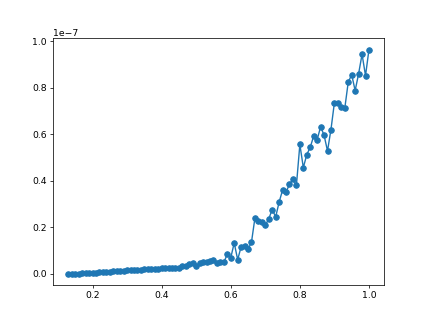

Starting experimental run with id: 933


933

In [205]:
ids = range(843, 931+1)
cos_list = np.arange(0.12, 1.01, 0.01)


Ics = jj.Isw_by_id(ids, fullIVC = False, dy = 50e-6)

Ej0 = 5.4

fig, ax = plt.subplots()
ax.plot(cos_list, Ics, 'o-')
# ax.plot(B_list, Ics, 'o-')


jj.mock_meas((Isw_param , Ics), (Ej_param, Ej0*cos_list),
             label = 'Isw vs cos')

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\KelvinOX25\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


no points in cut range
no points in cut range
no points in cut range
no points in cut range


<IPython.core.display.Javascript object>


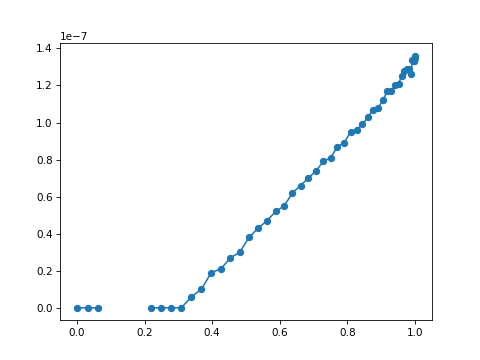

Starting experimental run with id: 1725


1725

In [160]:
jj79N6 = JJmeas(sample = 'D079N6')
jj79N6.db_connect()
jj79N6.ZF = 4e-6
jj79N6.FF = 232e-6



ids = range(763,813+1)
# jj79N6.bpbi(ids)


B_list =   np.linspace(4e-6, 232e-6, 51)
cos_list = jj79N6.B_to_cos(B_list)

Ics = jj79N6.Isw_by_id(ids, fullIVC = True, yoff = -.715e-3, dy = 10e-6)

Ej0 = 4.49

fig, ax = plt.subplots()
ax.plot(cos_list, Ics, 'o-')
# ax.plot(B_list, Ics, 'o-')


jj79N6.mock_meas((Isw_param , Ics), (Ej_param, Ej0*cos_list),
             label = 'Isw vs Ej')

### T scan

In [135]:
htr.HTRset('3.16mA')

'Heater changed = 3.16mA'

In [35]:
htr.output_range('3.16mA')

In [33]:
T8.get()

0.0344948

In [51]:
B = jj5.cos_to_B(0.2)
# B = 0e-6

print(B*1e3)

Bfield.set(B)

T_list = np.array( [40 + 10*i for i in range (17) ] )*1e-3

[            jj.IVC_udu (amp = 20e-12, stp = 0.2e-12, dt = .1,  N_avg = 1)
 
 for jj in   jj5.Tscan( T_list )]

htr_setpt.set(0.030)

0.19154216771905513


ramping T8 to 40.0 mK...
40.7 m
40.6 m
40.7 m
40.7 m
40.5 m
40.6 m
40.5 m
40.2 m
40.5 m
40.1 m
40.3 m
40.2 m
40.2 m
40.1 m
40.0 m
39.9 m
39.8 m
39.8 m
39.9 m
39.9 m
T is set


Starting experimental run with id: 1473
ramping T8 to 50.0 mK...
51.0 m
51.0 m
50.8 m
50.6 m
50.8 m
50.8 m
50.8 m
50.6 m
50.5 m
50.7 m
50.6 m
50.6 m
50.4 m
50.4 m
50.1 m
50.2 m
50.0 m
50.1 m
50.0 m
49.9 m
50.1 m
49.9 m
T is set


Starting experimental run with id: 1474
ramping T8 to 60.0 mK...
60.4 m
61.1 m
60.0 m
58.9 m
59.1 m
60.1 m
61.1 m
60.6 m
60.4 m
59.7 m
59.1 m
59.3 m
60.6 m
61.0 m
60.3 m
59.5 m
59.3 m
59.3 m
58.8 m
59.7 m
60.4 m
61.0 m
60.7 m
59.8 m
59.1 m
59.0 m
59.4 m
59.6 m
60.2 m
60.3 m
60.4 m
60.2 m
59.8 m
59.5 m
59.2 m
60.0 m
60.0 m
61.2 m
60.9 m
60.6 m
59.5 m
59.6 m
T is set


Starting experimental run with id: 1475
ramping T8 to 70.0 mK...
69.4 m
68.8 m
69.0 m
70.7 m
71.3 m
71.1 m
70.3 m
69.3 m
68.9 m
69.7 m
70.2 m
71.2 m
70.8 m
70.2 m
69.6 m
69.1 m
69.2 m
70.5 m
70.8 m
70.6 m
70.4 m
69.5 m
69.4 m
69.7 m
T is set


Starting experimental run with id: 1476
ramping T8 to 80.0 mK...
81.4 m
81.6 m
80.4 m
79.0 m
78.5 m
79.6 m
81.0 m
81.3 m
80.2 m
79.1 m
78.8 m
80.1 m
81.1 m
80.8 m
80.8 m
79.6 m
79.9 m
80.2 m
80.7 m
80.2 m
79.9 m
80.1 m
T is set


Starting experimental run with id: 1477
ramping T8 to 90.0 mK...
90.9 m
89.6 m
89.6 m
90.2 m
89.7 m
90.1 m
90.0 m
89.6 m
90.5 m
90.2 m
89.7 m
90.2 m
90.8 m
90.4 m
89.5 m
89.6 m
90.6 m
89.9 m
90.1 m
89.9 m
T is set


Starting experimental run with id: 1478
ramping T8 to 100.0 mK...
101.2 m
100.9 m
99.2 m
100.2 m
100.4 m
101.4 m
100.8 m
100.0 m
99.7 m
99.8 m
99.8 m
100.7 m
101.0 m
99.8 m
100.8 m
99.3 m
100.1 m
99.2 m
99.4 m
100.7 m
T is set


Starting experimental run with id: 1479
ramping T8 to 110.0 mK...
110.6 m
109.8 m
110.7 m
110.0 m
109.4 m
111.4 m
110.8 m
111.5 m
109.7 m
109.5 m
111.4 m
110.1 m
109.5 m
110.1 m
109.8 m
110.5 m
111.0 m
109.7 m
110.2 m
110.1 m
T is set


Starting experimental run with id: 1480
ramping T8 to 120.0 mK...
120.6 m
120.2 m
120.8 m
119.3 m
120.5 m
121.2 m
121.4 m
120.3 m
121.3 m
119.7 m
119.2 m
119.2 m
119.7 m
120.0 m
119.5 m
120.3 m
120.8 m
121.1 m
119.6 m
119.3 m
T is set


Starting experimental run with id: 1481
ramping T8 to 130.0 mK...
128.6 m
130.4 m
129.7 m
131.5 m
130.0 m
131.2 m
129.1 m
130.2 m
130.6 m
130.8 m
131.1 m
129.9 m
129.4 m
130.7 m
131.6 m
128.6 m
131.8 m
129.5 m
130.2 m
128.9 m
T is set


Starting experimental run with id: 1482
ramping T8 to 140.0 mK...
141.6 m
140.2 m
141.4 m
139.7 m
141.1 m
139.9 m
140.8 m
140.3 m
141.4 m
140.3 m
141.6 m
140.3 m
139.7 m
140.2 m
139.4 m
139.8 m
140.8 m
138.7 m
139.8 m
141.1 m
T is set


Starting experimental run with id: 1483
ramping T8 to 150.0 mK...
151.2 m
151.3 m
150.9 m
150.8 m
151.0 m
149.5 m
150.0 m
152.1 m
149.1 m
150.5 m
151.3 m
150.3 m
149.7 m
150.5 m
150.6 m
149.0 m
150.4 m
148.6 m
152.8 m
150.5 m
T is set


Starting experimental run with id: 1484
ramping T8 to 160.0 mK...
162.1 m
160.8 m
161.4 m
162.2 m
163.0 m
161.6 m
160.2 m
158.9 m
160.8 m
161.0 m
160.0 m
161.4 m
161.5 m
159.5 m
161.1 m
158.9 m
159.4 m
160.4 m
159.7 m
159.4 m
T is set


Starting experimental run with id: 1485
ramping T8 to 170.0 mK...
170.5 m
171.8 m
171.8 m
171.4 m
172.8 m
171.4 m
171.5 m
170.8 m
170.1 m
172.5 m
169.8 m
171.1 m
168.9 m
170.3 m
171.0 m
169.0 m
170.6 m
170.2 m
169.5 m
170.6 m
169.3 m
T is set


Starting experimental run with id: 1486
ramping T8 to 180.0 mK...
182.8 m
183.2 m
182.0 m
181.1 m
181.1 m
181.5 m
181.8 m
180.0 m
180.8 m
181.0 m
178.9 m
183.4 m
180.8 m
180.9 m
179.2 m
180.8 m
182.7 m
180.7 m
179.2 m
178.8 m
T is set


Starting experimental run with id: 1487
ramping T8 to 190.0 mK...
191.8 m
190.1 m
191.7 m
192.6 m
191.4 m
188.2 m
191.0 m
192.0 m
191.9 m
192.5 m
191.3 m
190.7 m
189.8 m
190.1 m
191.2 m
189.2 m
188.5 m
190.6 m
191.1 m
190.3 m
T is set


Starting experimental run with id: 1488
ramping T8 to 200.0 mK...
203.3 m
202.1 m
202.3 m
202.8 m
202.0 m
202.7 m
201.5 m
201.3 m
201.2 m
200.4 m
200.7 m
200.2 m
200.4 m
199.6 m
198.4 m
201.6 m
201.6 m
200.7 m
203.2 m
198.8 m
T is set


Starting experimental run with id: 1489



In [52]:
B = jj5.cos_to_B(0.3)
# B = 0e-6

print(B*1e3)

Bfield.set(B)

T_list = np.array( [40 + 10*i for i in range (17) ] )*1e-3

[            jj.IVC_udu (amp = 20e-12, stp = 0.2e-12, dt = .1,  N_avg = 1)
 
 for jj in   jj5.Tscan( T_list )]

htr_setpt.set(0.030)

0.17693791229481884


ramping T8 to 40.0 mK...
40.7 m
40.8 m
40.8 m
40.8 m
40.7 m
40.6 m
40.6 m
40.6 m
40.6 m
40.6 m
40.4 m
40.3 m
40.5 m
40.4 m
40.4 m
40.3 m
40.2 m
40.1 m
40.0 m
40.1 m
40.1 m
40.1 m
39.9 m
40.0 m
T is set


Starting experimental run with id: 1490
ramping T8 to 50.0 mK...
50.9 m
50.8 m
50.8 m
50.3 m
50.7 m
51.0 m
50.6 m
50.4 m
50.2 m
50.1 m
50.1 m
50.1 m
49.9 m
50.3 m
50.2 m
49.8 m
49.9 m
49.7 m
49.7 m
49.8 m
T is set


Starting experimental run with id: 1491
ramping T8 to 60.0 mK...
60.6 m
61.2 m
60.1 m
59.4 m
59.1 m
58.8 m
59.6 m
61.1 m
60.4 m
59.9 m
59.2 m
59.2 m
59.0 m
60.1 m
60.8 m
60.8 m
61.1 m
60.3 m
59.5 m
59.4 m
58.9 m
59.3 m
60.0 m
60.7 m
61.0 m
60.4 m
60.5 m
59.9 m
58.9 m
58.9 m
59.6 m
T is set


Starting experimental run with id: 1492
ramping T8 to 70.0 mK...
69.6 m
68.8 m
68.6 m
70.6 m
71.3 m
70.7 m
69.9 m
69.0 m
68.8 m
70.1 m
71.2 m
70.9 m
70.4 m
69.7 m
68.9 m
69.3 m
70.1 m
70.6 m
69.6 m
70.1 m
70.0 m
69.5 m
70.2 m
69.9 m
70.1 m
69.9 m
T is set


Starting experimental run with id: 1493
ramping T8 to 80.0 mK...
78.6 m
81.2 m
81.4 m
80.1 m
78.7 m
78.7 m
80.1 m
80.2 m
80.4 m
80.3 m
79.6 m
79.6 m
79.9 m
80.2 m
80.3 m
80.1 m
79.9 m
79.9 m
78.9 m
80.3 m
80.5 m
80.4 m
T is set


Starting experimental run with id: 1494
ramping T8 to 90.0 mK...
90.7 m
90.2 m
90.2 m
90.0 m
89.7 m
91.0 m
90.3 m
89.4 m
89.8 m
89.7 m
89.8 m
89.9 m
90.4 m
89.8 m
90.3 m
90.2 m
89.6 m
90.7 m
89.6 m
90.3 m
T is set


Starting experimental run with id: 1495
ramping T8 to 100.0 mK...
100.7 m
100.5 m
100.3 m
100.4 m
100.0 m
100.4 m
100.5 m
101.1 m
100.7 m
99.5 m
100.3 m
100.1 m
99.4 m
99.9 m
100.2 m
99.9 m
100.6 m
100.2 m
100.0 m
99.7 m
T is set


Starting experimental run with id: 1496
ramping T8 to 110.0 mK...
110.9 m
110.2 m
109.7 m
110.1 m
110.8 m
109.7 m
109.9 m
110.1 m
110.0 m
110.2 m
110.1 m
109.3 m
110.5 m
109.2 m
110.4 m
109.9 m
110.2 m
110.1 m
110.1 m
111.5 m
T is set


Starting experimental run with id: 1497
ramping T8 to 120.0 mK...
120.5 m
119.1 m
121.6 m
121.8 m
120.8 m
121.1 m
120.6 m
120.3 m
120.8 m
120.6 m
120.6 m
121.4 m
119.9 m
120.8 m
119.1 m
120.0 m
120.8 m
119.6 m
120.2 m
120.8 m
T is set


Starting experimental run with id: 1498
ramping T8 to 130.0 mK...
131.3 m
130.3 m
131.2 m
131.2 m
129.5 m
131.0 m
129.4 m
130.6 m
128.9 m
129.7 m
131.0 m
129.8 m
130.2 m
130.6 m
130.3 m
129.7 m
129.8 m
129.5 m
129.5 m
131.1 m
T is set


Starting experimental run with id: 1499
ramping T8 to 140.0 mK...
140.7 m
141.0 m
141.2 m
140.2 m
141.9 m
140.0 m
140.7 m
138.9 m
140.4 m
139.9 m
141.4 m
140.4 m
142.7 m
140.0 m
139.7 m
140.7 m
139.5 m
139.6 m
139.7 m
139.1 m
T is set


Starting experimental run with id: 1500
ramping T8 to 150.0 mK...
151.4 m
150.7 m
150.8 m
149.8 m
150.4 m
148.3 m
150.6 m
149.0 m
150.7 m
150.5 m
152.7 m
149.9 m
151.5 m
151.9 m
147.8 m
149.1 m
148.8 m
149.7 m
150.8 m
151.0 m
T is set


Starting experimental run with id: 1501
ramping T8 to 160.0 mK...
161.7 m
161.6 m
161.4 m
159.2 m
159.9 m
160.8 m
161.8 m
161.2 m
160.8 m
160.5 m
160.7 m
159.6 m
160.1 m
160.4 m
159.3 m
159.0 m
159.0 m
161.3 m
160.2 m
159.2 m
T is set


Starting experimental run with id: 1502
ramping T8 to 170.0 mK...
173.2 m
170.4 m
170.5 m
170.3 m
170.3 m
171.6 m
168.9 m
169.4 m
171.0 m
169.7 m
170.4 m
171.9 m
170.1 m
169.7 m
171.0 m
169.5 m
168.9 m
170.8 m
170.0 m
169.0 m
T is set


Starting experimental run with id: 1503
ramping T8 to 180.0 mK...
181.5 m
181.1 m
183.3 m
182.7 m
179.4 m
181.7 m
179.7 m
182.8 m
181.1 m
179.8 m
180.9 m
181.0 m
180.9 m
181.0 m
180.4 m
177.8 m
178.5 m
180.2 m
181.3 m
180.8 m
178.4 m
180.5 m
180.5 m
T is set


Starting experimental run with id: 1504
ramping T8 to 190.0 mK...
191.6 m
192.9 m
191.5 m
192.3 m
190.0 m
191.3 m
192.6 m
193.0 m
191.6 m
191.5 m
190.5 m
191.7 m
191.5 m
191.8 m
190.6 m
191.1 m
189.4 m
190.8 m
191.5 m
186.6 m
191.3 m
190.5 m
T is set


Starting experimental run with id: 1505
ramping T8 to 200.0 mK...
201.3 m
203.3 m
201.3 m
203.6 m
198.8 m
201.0 m
202.2 m
200.2 m
201.6 m
200.7 m
198.9 m
201.6 m
199.0 m
200.0 m
201.4 m
200.9 m
199.4 m
200.1 m
199.4 m
200.6 m
198.4 m
201.9 m
T is set


Starting experimental run with id: 1506



In [ ]:
[            jj.IVC_fwd (amp = 1e-12, stp = 0.025e-12, dt = .5, N_avg = 100)
for jj in    jj.Tscan( [200e-3] )]

htr.set(0.030)

In [36]:
np.array( [40 + 10*i for i in range (17) ] )*1e-3

array([0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14,
       0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [44]:
htr_setpt.set(30e-3)

In [13]:
htr.output_range('3.16mA')

In [28]:
T_list = np.array( [50 + 25*i for i in range (11) ] )*1e-3
B_list = np.linspace(0, 1.85e-3, 11)

for jj in  jj.Tscan( T_list ):
    
    for jj in jj.Bscan(B_list):
    
        jj.IVC_udu (amp = 1e-12, stp = 0.01e-12, dt = .5, Ioff = -.5e-12)
    
    
Bfield.set(0e-3)
htr_setpt.set(30e-3)

ramping T8 to 50.0 mK...
50.9 m
50.7 m
50.7 m
50.9 m
51.0 m
50.5 m
50.5 m
50.3 m
50.6 m
50.2 m
50.2 m
50.2 m
49.9 m
49.6 m
49.8 m
50.1 m
50.0 m
49.6 m
49.7 m
49.5 m
49.7 m
49.6 m
T is set


Starting experimental run with id: 912


Starting experimental run with id: 913


Starting experimental run with id: 914


Starting experimental run with id: 915


Starting experimental run with id: 916


Starting experimental run with id: 917


Starting experimental run with id: 918


Starting experimental run with id: 919


Starting experimental run with id: 920


Starting experimental run with id: 921


Starting experimental run with id: 922

{ 'ids' : range(912,922+1), 'B' : np.linspace(0.00e+00,1.85e-03, 11), 'T' : 0.050, 'comm : '' }
ramping T8 to 75.0 mK...


VisaIOError: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking 'RDGK? 8\\n\\r' to <Model_372: LS370 input Ch>", 'getting LS370 input Ch_ch08_temperature')

In [ ]:
T_list = np.array( [200 + 25*i for i in range (5) ] )*1e-3
B_list = np.linspace(0, 1.85e-3, 11)

for jj in  jj.Tscan( T_list ):
    
    for jj in jj.Bscan(B_list):
    
        jj.IVC_fwd (amp = 2e-12, stp = 0.04e-12, dt = .5, Ioff = -.35e-12)
    
    
Bfield.set(0e-3)
htr_setpt.set(30e-3)

## Snapshot

In [778]:
station.snapshot()

{'instruments': {'K6220': {'functions': {},
   'submodules': {},
   '__class__': 'qcodes.instrument_drivers.Keithley.Keithley_6220_Isrc.Keithley_6220_Isrc',
   'parameters': {'IDN': {'value': {'vendor': 'KEITHLEY INSTRUMENTS INC.',
      'model': '6220',
      'serial': '1249187',
      'firmware': 'A05  /700x'},
     'ts': '2020-07-22 15:02:02',
     'raw_value': {'vendor': 'KEITHLEY INSTRUMENTS INC.',
      'model': '6220',
      'serial': '1249187',
      'firmware': 'A05  /700x'},
     '__class__': 'qcodes.instrument.parameter.Parameter',
     'full_name': 'K6220_IDN',
     'label': 'IDN',
     'name': 'IDN',
     'instrument': 'qcodes.instrument_drivers.Keithley.Keithley_6220_Isrc.Keithley_6220_Isrc',
     'instrument_name': 'K6220',
     'inter_delay': 0,
     'post_delay': 0,
     'unit': '',
     'vals': '<Anything>'},
    'timeout': {'value': 10.0,
     'ts': '2020-07-27 13:33:51',
     'raw_value': 10.0,
     '__class__': 'qcodes.instrument.parameter.Parameter',
     'full_na

In [784]:
snap=station.snapshot()

In [904]:
snap['instruments']['K6220']['parameters']['IDN']['__class__']

'qcodes.instrument.parameter.Parameter'

In [890]:
from JJmeasurement_Plamen import *
import QCmeasurement_Plamen

In [891]:
jjmock=JJmeas_Pl(sample='mock',tools=tools)

In [906]:
x=np.linspace(-np.pi,np.pi)
y=np.sin(x)
V=Parameter('V')
I=Parameter('I')
dataset=jjmock.mock_meas_P((V,y),(I,x))

Starting experimental run with id: 17


<IPython.core.display.Javascript object>


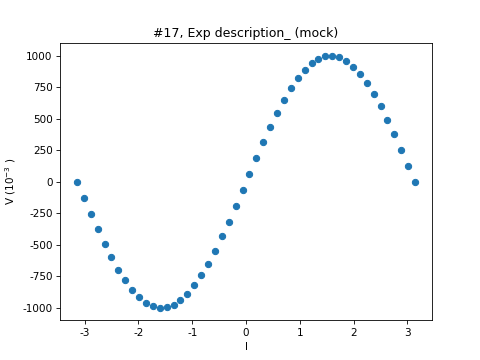

In [907]:
jjmock.pbi(17)

In [905]:
dataset1=dataset.snapshot

In [908]:
dataset2=dataset.snapshot

In [909]:
from qcodes.utils.metadata import diff_param_values



In [910]:
diff_param_values(dataset1, dataset2).changed


{}